## <u>*Classsification Modelling for Area as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os

In [2]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm"],axis=1)

In [3]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

---

In [4]:
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df["numclaims"]=df["numclaims"].astype("object")

*Date preprocessing*

In [5]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [6]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat
14,1.66,0.484600,1,669.509999,9,2,1,1,5
16,1.51,0.993840,1,806.609999,9,2,0,5,3
17,0.76,0.539357,1,401.805451,3,2,1,2,3
40,1.89,0.654346,2,1811.709997,10,2,1,5,1
64,4.06,0.851472,1,5434.439987,10,1,1,5,2


*Define x and y*

In [7]:
x=df.drop("veh_body",axis=1)
y=df["veh_body"]

In [8]:
df["veh_body"].value_counts()

veh_body
9     1476
3     1264
10    1173
12     260
4      130
11     120
2       68
7       62
6       43
5       14
0        9
1        3
8        2
Name: count, dtype: int64

*apply data balance method*

In [9]:
from imblearn.over_sampling import SMOTE
smk=SMOTE(random_state=41,k_neighbors=1)
x,y=smk.fit_resample(x,y)

*Splitting data into training and testing subsets*

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (15350, 8) and Y = (15350,) : 
Test data shape of X = (3838, 8) and Y = (3838,) : 


*Data Scaling*

In [11]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

---

## *Hyperparamers tunning*

* *Defining models and its parameters*

In [17]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        
}

search_spaces ={        
        "XGBRFClassifier":{
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),    # 0.3 is the default
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "subsample": hp.uniform("subsample",0.5,1.0),
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            'colsample_bytree': hp.uniform("colsample_bytree",0.5,1.0), 
            'colsample_bynode': hp.uniform("colsample_bynode",0.5,1.0),
            "reg_lambda": hp.quniform("reg_lambda",0,2,1),           #L2 regularization term on weights. Increasing this value will make model more conservative
            "reg_alpha": hp.quniform("reg_alpha",0,2,1),
            "num_parallel_tree": hp.choice("num_parallel_tree", [100,110])
            },
        "GradientBoostingClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "max_features": hp.choice("max_features",["sqrt", "log2"]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),
            "subsample": hp.uniform("subsample",0.8,1.0),
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0)
            },
        "RandomForestClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]), 
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
            "bootstrap": hp.choice("bootstrap",[True, False]),                                                                                                    
            "max_features": hp.choice("max_features",["sqrt", "log2"]),                                    
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "criterion": hp.choice("criterion",["gini", "entropy", "log_loss"])                    
        },
        "AdaBoostClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0)
        },
        "DecisionTreeClassifier": {
                    "criterion": hp.choice("criterion",["gini", "entropy", "log_loss"]),
                    'splitter': hp.choice("splitter",["best", "random"]),
                    "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
                    "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
                    "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
                    "max_features": hp.choice("max_features",["sqrt", "log2"])
        }                    
}

* *AdaBoostClassifier hyperparameter*

In [13]:
space=search_spaces["AdaBoostClassifier"]
def hyperparameter_tuning(space):
    clf = AdaBoostClassifier(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_AdaBoostClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_AdaBoostClassifier)    

100%|██████████| 10/10 [04:19<00:00, 26.00s/trial, best loss: -0.26488599348534203]
{'learning_rate': np.float64(0.7324824558563362), 'n_estimators': np.int64(1)}


* *GradientBoostingClassifier hyperparameter*

In [14]:
space=search_spaces["GradientBoostingClassifier"]
def hyperparameter_tuning(space):
    clf = GradientBoostingClassifier(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_GradientBoostingClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_GradientBoostingClassifier)    

100%|██████████| 10/10 [11:00<00:00, 66.01s/trial, best loss: -0.07850162866449512]
{'learning_rate': np.float64(0.49988273942205647), 'max_depth': np.int64(1), 'max_features': np.int64(0), 'min_samples_leaf': np.float64(0.9969671357605456), 'min_samples_split': np.float64(0.973036569276072), 'n_estimators': np.int64(5), 'subsample': np.float64(0.9938746734442501)}


* *RandomForestClassifier hyperparameter*

In [16]:
space=search_spaces["RandomForestClassifier"]
def hyperparameter_tuning(space):
    clf = RandomForestClassifier(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_RandomForestClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_RandomForestClassifier)         

100%|██████████| 10/10 [00:58<00:00,  5.88s/trial, best loss: -0.07882736156351791]
{'bootstrap': np.int64(1), 'criterion': np.int64(0), 'max_depth': np.int64(1), 'max_features': np.int64(0), 'min_samples_leaf': np.float64(0.9548293480149039), 'min_samples_split': np.float64(0.8548369013052135), 'n_estimators': np.int64(3)}


* *XGBRFClassifier hyperparameter*

In [18]:
space=search_spaces["XGBRFClassifier"]
def hyperparameter_tuning(space):
    clf = XGBRFClassifier(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_XGBRFClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_XGBRFClassifier)          

100%|██████████| 10/10 [09:28<00:00, 56.87s/trial, best loss: -0.7393485342019545]
{'colsample_bynode': np.float64(0.8242226665175306), 'colsample_bytree': np.float64(0.8029099521062315), 'learning_rate': np.float64(0.25726849104466526), 'max_depth': np.int64(4), 'n_estimators': np.int64(1), 'num_parallel_tree': np.int64(0), 'reg_alpha': np.float64(1.0), 'reg_lambda': np.float64(1.0), 'subsample': np.float64(0.7181215732378148)}


In [20]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestParams/veh_body_best_XGBRFClassifier.pkl","wb") as f:
    pickle.dump(best_XGBRFClassifier,f)

### *Final Result*

* *XGBRFClassifier model has the best and the lowest loss*

In [19]:
model = XGBRFClassifier(**best_XGBRFClassifier)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print(classification_report(y_test,predicted))


              precision    recall  f1-score   support

           0       0.73      0.60      0.66       321
           1       0.92      0.95      0.94       285
           2       0.36      0.52      0.42       290
           3       0.18      0.09      0.12       276
           4       0.24      0.43      0.31       328
           5       0.63      0.81      0.71       296
           6       0.36      0.37      0.37       293
           7       0.31      0.45      0.37       300
           8       0.90      1.00      0.95       274
           9       0.31      0.19      0.23       297
          10       0.34      0.13      0.18       271
          11       0.30      0.24      0.27       303
          12       0.28      0.19      0.22       304

    accuracy                           0.46      3838
   macro avg       0.45      0.46      0.44      3838
weighted avg       0.45      0.46      0.44      3838



In [21]:
unique_labels(y_test)
labels=unique_labels(y_test)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(y_test, predicted),columns=col_names,index=index_names)

,predicted0,predicted1,predicted2,predicted3,predicted4,predicted5,predicted6,predicted7,predicted8,predicted9,predicted10,predicted11,predicted12
Actual0,194,0,11,0,49,0,22,44,0,0,1,0,0
Actual1,0,271,0,0,14,0,0,0,0,0,0,0,0
Actual2,0,0,150,11,31,6,14,36,4,18,0,14,6
Actual3,8,0,76,24,27,5,29,37,0,34,10,15,11
Actual4,10,0,9,12,141,38,23,25,1,17,7,19,26
Actual5,0,13,0,1,24,240,0,6,0,0,1,9,2
Actual6,3,0,17,1,72,9,109,44,0,16,4,9,9
Actual7,1,0,46,15,48,4,11,135,0,0,0,31,9
Actual8,0,0,0,0,0,0,0,0,274,0,0,0,0
Actual9,8,1,47,28,44,15,17,27,4,55,15,17,19


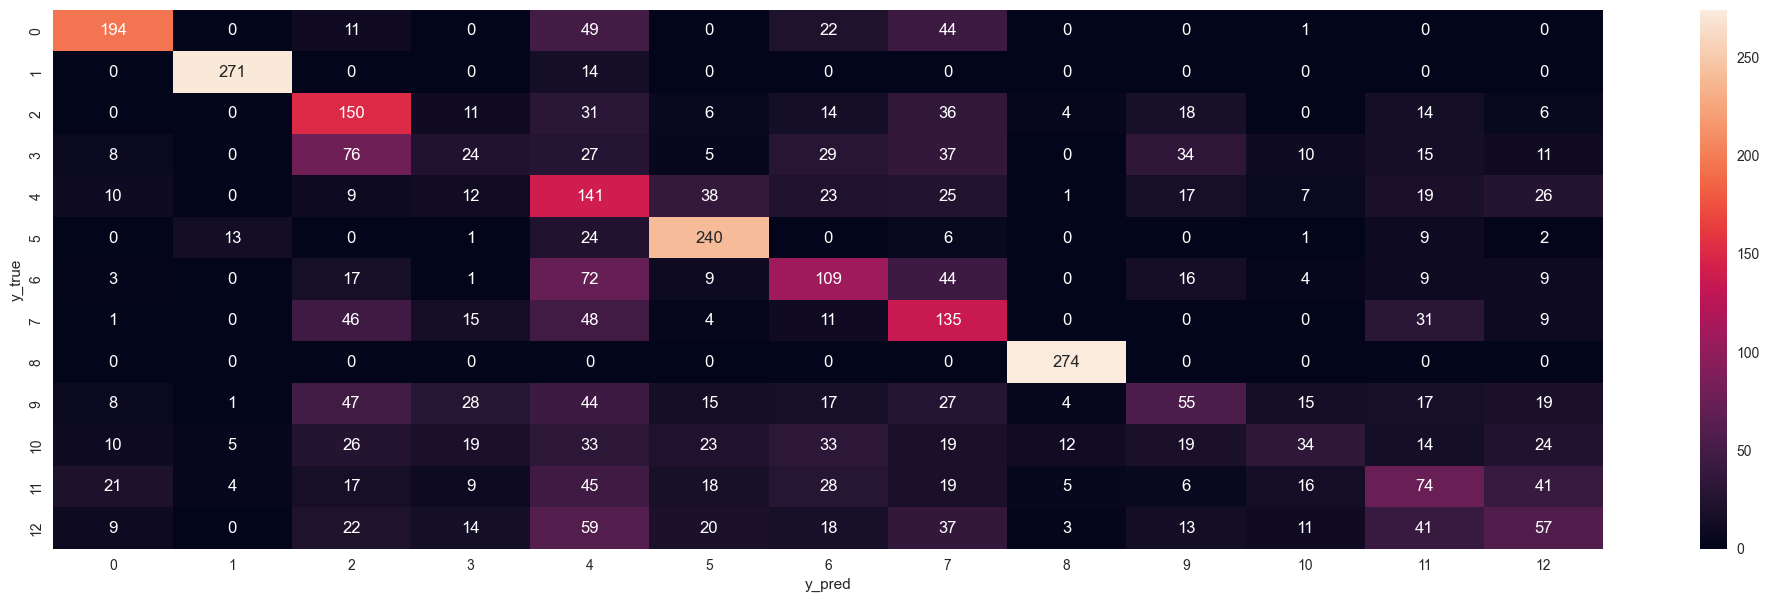

In [22]:
matplotlib.rcParams["figure.figsize"]=(25,7)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,linecolor = "red", fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true");

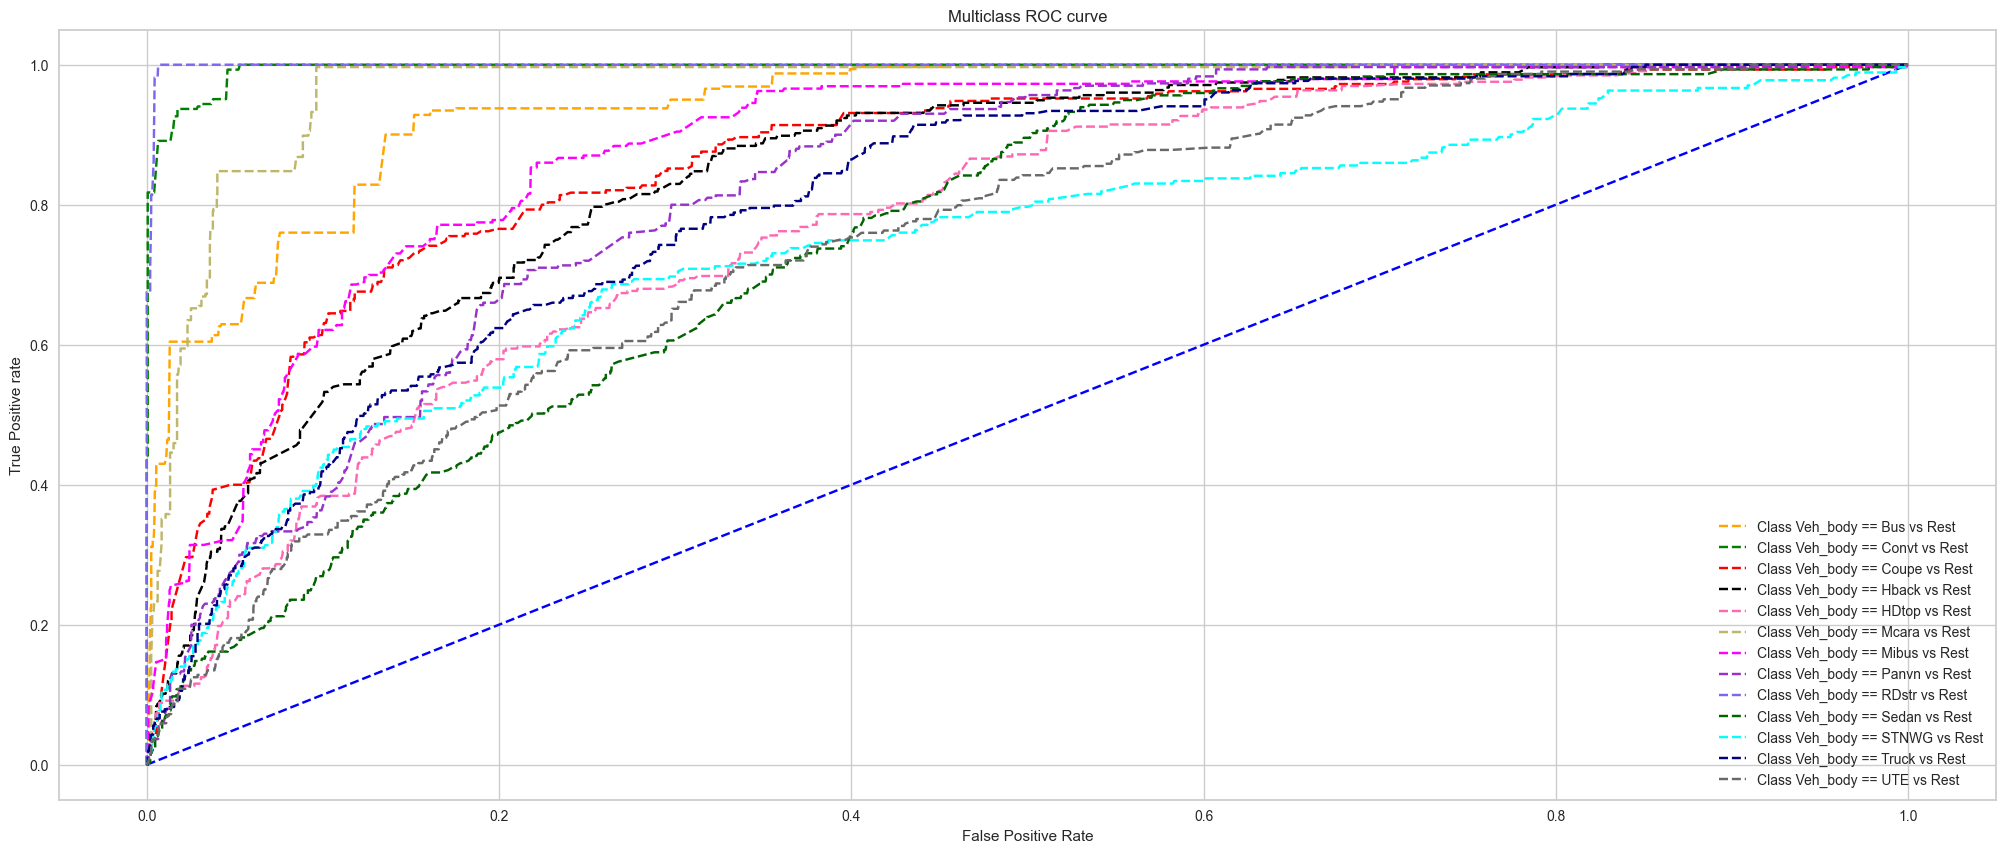

In [24]:
from sklearn.multiclass import OneVsRestClassifier
matplotlib.rcParams["figure.figsize"]=(25,10)
clf = OneVsRestClassifier( XGBRFClassifier(**best_XGBRFClassifier)).fit(x_train,y_train)


clf.fit(x_train, y_train)
pred = clf.predict(x_test)
pred_prob = clf.predict_proba(x_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 13

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class Veh_body == Bus vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class Veh_body == Convt vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class Veh_body == Coupe vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='black', label='Class Veh_body == Hback vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='HotPink', label='Class Veh_body == HDtop vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='DarkKhaki', label='Class Veh_body == Mcara vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='Magenta', label='Class Veh_body == Mibus vs Rest')
plt.plot(fpr[7], tpr[7], linestyle='--',color='DarkOrchid', label='Class Veh_body == Panvn vs Rest')
plt.plot(fpr[8], tpr[8], linestyle='--',color='MediumSlateBlue', label='Class Veh_body == RDstr vs Rest')
plt.plot(fpr[9], tpr[9], linestyle='--',color='DarkGreen', label='Class Veh_body == Sedan vs Rest')
plt.plot(fpr[10], tpr[10], linestyle='--',color='Aqua', label='Class Veh_body == STNWG vs Rest')
plt.plot(fpr[11], tpr[11], linestyle='--',color='Navy', label='Class Veh_body == Truck vs Rest')
plt.plot(fpr[12], tpr[12], linestyle='--',color='DimGray', label='Class Veh_body == UTE vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best');
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/MulticlassROCGraphs/veh_body_MulticlassROCGraphs.png',dpi=500);

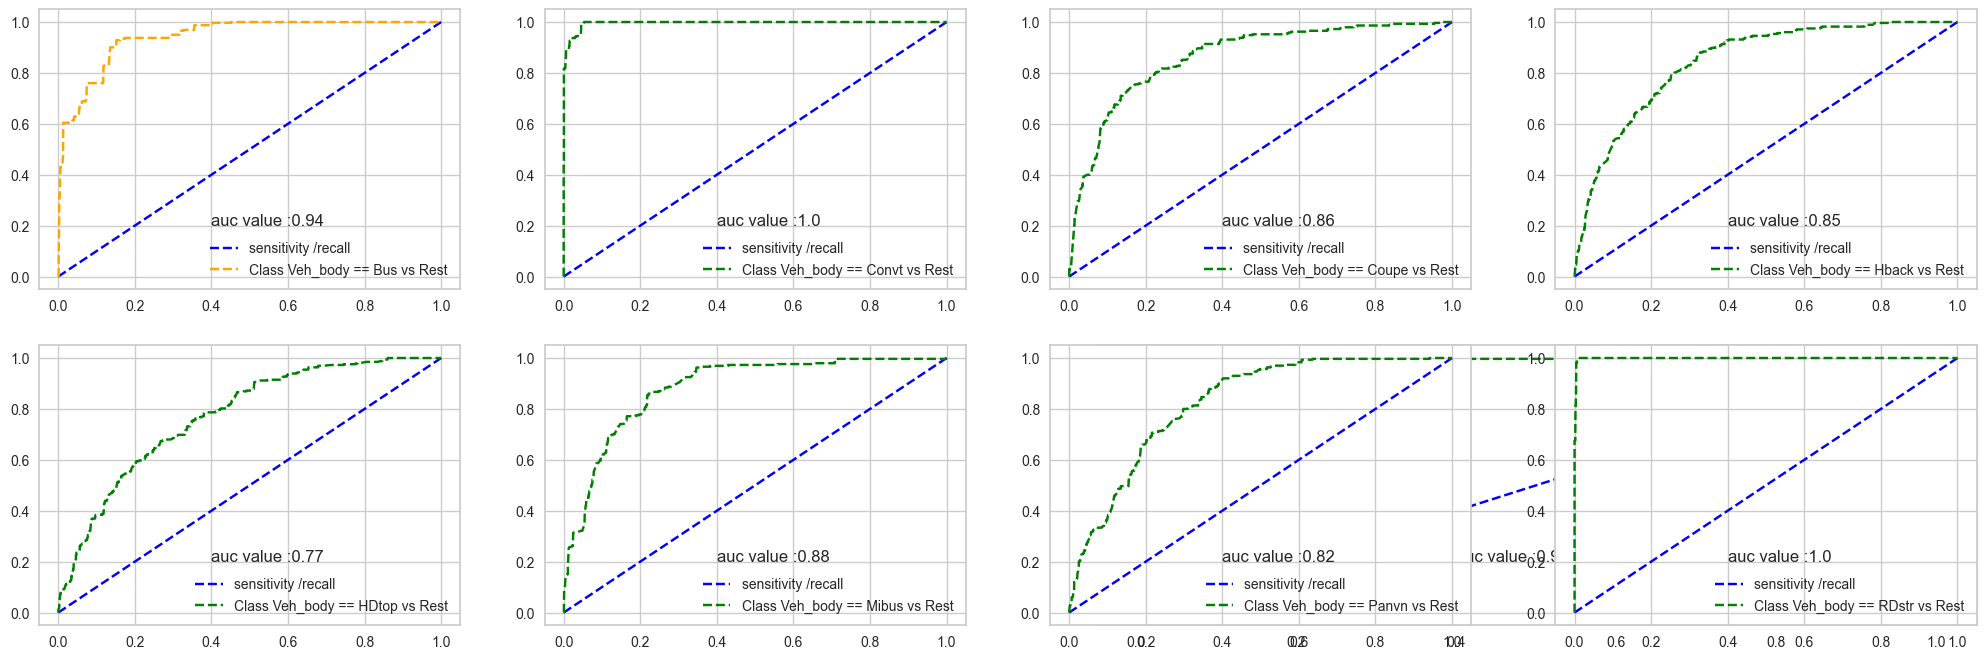

In [25]:
matplotlib.rcParams["figure.figsize"]=(25,8)
plt.subplot(241)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[0], tpr[0]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Bus vs Rest'])

plt.subplot(242)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[1], tpr[1]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Convt vs Rest'])

plt.subplot(243)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[2], tpr[2], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[2], tpr[2]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Coupe vs Rest'])

plt.subplot(244)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[3], tpr[3], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[3], tpr[3]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Hback vs Rest'])

plt.subplot(245)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[4], tpr[4], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[4], tpr[4]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == HDtop vs Rest'])

plt.subplot(224)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[5], tpr[5], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[5], tpr[5]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Mcara vs Rest'])

plt.subplot(246)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[6], tpr[6], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[6], tpr[6]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Mibus vs Rest'])


plt.subplot(247)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[7], tpr[7], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[7], tpr[7]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Panvn vs Rest'])

plt.subplot(248)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[8], tpr[8], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[8], tpr[8]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == RDstr vs Rest']);

plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/ROCcurveGraphs/veh_body1_ROCcurveGraphs.png',dpi=500);

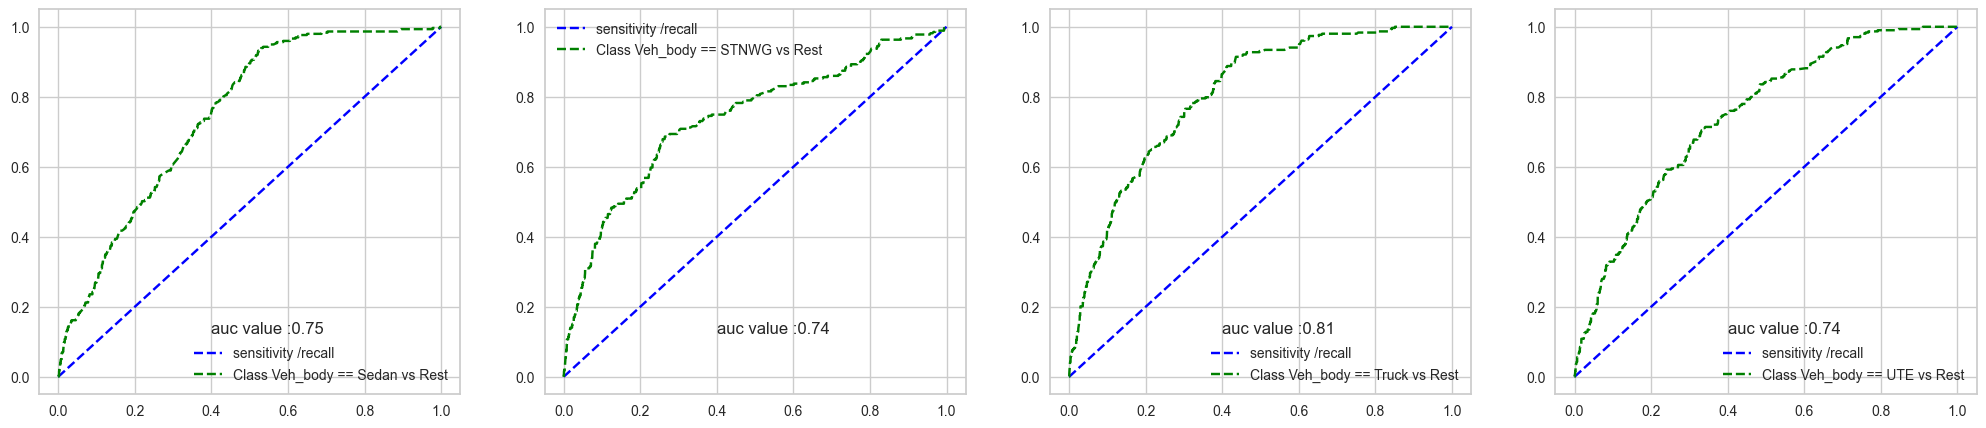

In [26]:
matplotlib.rcParams["figure.figsize"]=(25,5)
plt.subplot(141)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[9], tpr[9], linestyle='--',color='green')
plt.text(0.4,0.125, f'auc value :{round(auc(fpr[9], tpr[9]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Sedan vs Rest'])

plt.subplot(142)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[10], tpr[10], linestyle='--',color='green')
plt.text(0.4,0.125, f'auc value :{round(auc(fpr[10], tpr[10]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == STNWG vs Rest'])


plt.subplot(143)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[11], tpr[11], linestyle='--',color='green')
plt.text(0.4,0.125,f'auc value :{round(auc(fpr[11], tpr[11]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Truck vs Rest'])


plt.subplot(144)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[12], tpr[12], linestyle='--',color='green')
plt.text(0.4,0.125, f'auc value :{round(auc(fpr[12], tpr[12]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == UTE vs Rest']);

plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/ROCcurveGraphs/veh_body2_ROCcurveGraphs.png',dpi=500);

In [27]:
model.feature_names_in=x.columns
importance=pd.concat([pd.DataFrame(model.feature_names_in,columns=["feature_names"]),
           pd.DataFrame(model.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.304954
1,exposure,0.042943
2,numclaims,0.016197
3,claimcst0,0.186365
4,veh_age,0.187928
5,gender,0.083430
6,area,0.129746
7,agecat,0.048438


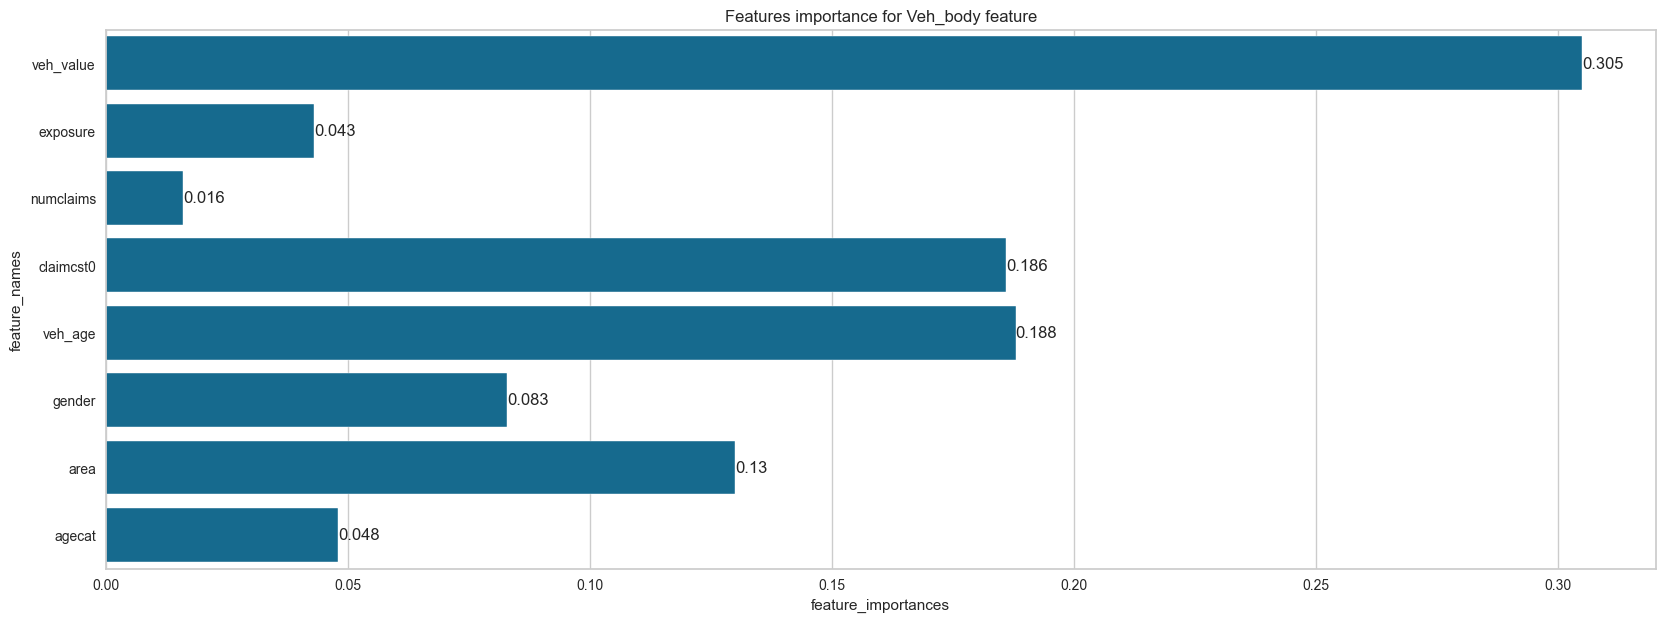

In [28]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Veh_body feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/veh_body_featureImportanc.png',dpi=500);

In [29]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/veh_body_prediction_model.pkl","wb") as f:
    pickle.dump(model,f)